Development/Execution/Data Testing: Carl Hongyu Liu - Msc Pharmaceutics | University College London, UK
hong.liu.24@ucl.ac.uk carlos.liu-2024@alumni.utoronto.ca


Co-Development/Coding/Consultation: James Hongdian Liu - BAsc Management Engineering | University of Waterloo, Canada
j58liu@uwaterloo.ca




# Formulation Bayesian Optimization Platform: A Multi-objective Bayesian Optimizer for Formulation Optimization
David Shorthouse Lab - University College London

**Requirements:**  
pip install botorch gpytorch pandas torch

Do not mix pip and conda install torch or kernel will crash

### Welcome, for your reference, here is an example workflow of how this program should be used



            


Suppose you are trying to optimize a formulation, the formulation contains: drug, binder, bulking agent, surfactants. Adjusting these parameters to get the desirable physical properties like release, dissolution, viscosity, and etc.

1.	Prepare your design‐space CSV

	        List every formulation as a row, with columns for each excipient concentration and empty columns for your target properties (e.g. viscosity, surface tension, nebulization efficiency).

2.	Initialize FBOP and suggest first experiments

	        Load the CSV into pandas.
	        Draw 5 Sobol (or random) samples from the design space.
	        Mark those rows as pending = True, clear their property‐columns.
	        Export this as formulation_design_space.csv for your lab team.

3.	Run the experiments

	        In the lab, prepare each suggested formulation.
	        Measure the target properties and fill in the CSV.

4.	Incorporate observed data

	        Reload the updated FBOP_suggestions.csv.
	        Separate out the now‐completed (pending=False) rows.
	        Build your training set:
	        Features X = excipient concentrations
	        Targets Y = measured properties

5.	Fit single/multi‐objective surrogate models

	        Normalize X into [0,1]^d.
	        Fit one SingleTaskGP per property, maximize its log‐marginal likelihood.
	        Wrap them into a ModelListGP for joint prediction.

6.	Construct the EI/qEHVI acquisition function

	        Compute a reference point just below your worst observed Y.
	        Instantiate qLogNoisyExpectedHypervolumeImprovement with a SobolQMCNormalSampler.

7.	Optimize EI/qEHVI to propose new runs

	        Call optimize_acqf over the unit cube [0,1]^d for q new candidates.
	        Unnormalize the resulting points back to real concentrations.

8.	Prepare next‐round suggestion file

	        Create a DataFrame of the new q points, set their property columns to NaN, pending = True.
	        Append them to your master suggestions and export as FBOP_round2_suggestions.csv.

9.	Iterate until stopping

	        Repeat steps 3–8, gradually filling out your design space and refining the Pareto front.
	        Adjust batch size q, priority flags, or surrogate hyperparameters as needed.

10.	Analyze final results

	        Once you’ve exhausted resources or reached convergence, compile all observed runs.
	        Plot the surrogate‐predicted Pareto front versus true measurements.
	        Select the formulations that best balance your objectives (e.g. high viscosity, low surface tension, high nebulization efficiency).

In [2]:
pip show botorch

Name: botorch
Version: 0.15.0
Summary: Bayesian Optimization in PyTorch
Home-page: https://botorch.org
Author: Meta Platforms, Inc.
Author-email: 
License: MIT
Location: c:\users\72784\anaconda3\envs\pytorch_clean\lib\site-packages
Requires: gpytorch, linear_operator, multipledispatch, pyre_extensions, pyro-ppl, scipy, threadpoolctl, torch, typing_extensions
Required-by: 
Note: you may need to restart the kernel to use updated packages.


In [1]:
# core data libraries
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
# PyTorch + BoTorch + GPyTorch
import torch
from botorch.models import SingleTaskGP, ModelListGP
from gpytorch.mlls import ExactMarginalLogLikelihood
from botorch.fit import fit_gpytorch_mll
from botorch.optim import optimize_acqf
from botorch.models.transforms import Normalize
from botorch.models.transforms.outcome import Standardize
from botorch.utils.transforms import normalize, unnormalize
from botorch.sampling import SobolQMCNormalSampler
from botorch.acquisition.logei import qLogExpectedImprovement
from botorch.acquisition.multi_objective.logei import qLogExpectedHypervolumeImprovement 
from botorch.acquisition.multi_objective.logei import qLogNoisyExpectedHypervolumeImprovement 
from botorch.utils.multi_objective.box_decompositions.non_dominated import FastNondominatedPartitioning
from botorch.acquisition.multi_objective.objective import FeasibilityWeightedMCMultiOutputObjective
from botorch.acquisition.monte_carlo import SampleReducingMCAcquisitionFunction
from botorch.acquisition.multi_objective.objective import IdentityMCMultiOutputObjective






### GPU or CPU?
Botorch can utilize your GPU/CUDA for faster runtime. You could leverage your GPU for Extra performance


#### Advanced settings :

- CPU or CUDA: Would you like to use CPU or GPU
- Float 32: Lower quality tensor requiring the least amount of memory cache
- Float 64: Higher quality tensor that doubles the amount of cache required for 32



In [2]:

# Only ask for device (GPU/CPU) and tensor float type (32/64)
if torch.cuda.is_available():
    use_gpu = input("Use GPU for computations? (y/n): ").strip().lower()
    if use_gpu == "y":
        device = torch.device("cuda")
        print("Using GPU for computations.")
    else:
        device = torch.device("cpu")
        print("Using CPU for computations.")
else:
    print("CUDA not available, using CPU.")
    device = torch.device("cpu")

float_type = input("Tensor float32 or float64? (32/64): ").strip()
if float_type == "32":
    tensor_float = torch.float32
elif float_type == "64":
    tensor_float = torch.float64
else:
    print("Invalid input, defaulting to float64.")
    tensor_float = torch.float64



print(f"Using device: {device}")
print(f"Using tensor type: {tensor_float}")

Using GPU for computations.
Using device: cuda
Using tensor type: torch.float64


### 1.1 Import Your CSV File

Your CSV file should follow this style:

In [ ]:
# EXCIPIENTS  excipient_A  excipient_B  excipient_C  PROPERTIES  property_1  property_2  property_3  NOISE  NOISE_1  NOISE_2  NOISE_3
#                     0.1          0.2          0.7                    NaN          NaN         NaN         NaN      NaN      NaN     
#                     0.2          0.1          0.7                    NaN          NaN         NaN         NaN      NaN      NaN      
#         …

"""
to construct bounds, you need to include the min and max values for each excipient, even if they 
do not have an observed value. The BO will not invstigate further beyond the bounds.

Noise columns can be optional, but if included, they should be filled with standard error of the mean.    
"""


In [86]:
# Your CSV should list every possible formulation combination,
# with columns for each excipient concentration, plus (empty) columns
# for the measured objectives.

# Load the design space from a CSV file
file_path = "datacopy.csv"
#file_path = input("Enter the path to your design-space CSV file: ")
df = pd.read_csv(file_path)
df.head()

,EXCIPIENTS,P407,P188,Tween80,PG,PROPERTIES,Solubility,Tgel,Particle_Size,NOISE,variance release,variance tgel,variance PS
0,1,1.704575,0.798600,0.0575,0.2060,NaN,0.248865,45.0,5.4245,NaN,0.000148,0.00,0.354620
1,2,1.860250,0.000000,0.0536,0.8229,NaN,0.343033,24.5,6.3070,NaN,0.000030,0.25,2.414916
2,3,1.906900,0.826400,0.0262,1.0011,NaN,0.535910,32.0,31.4000,NaN,0.000078,0.00,144.000000
3,4,1.602100,0.402825,0.0760,0.4117,NaN,0.422814,45.0,193.5000,NaN,0.000060,0.00,2016.010000
4,5,1.500400,0.597825,0.1032,0.4106,NaN,0.320340,47.0,56.9400,NaN,0.000144,0.00,0.220900


### 1.2 Initial Design of Experiments, formatting your CSV

In [87]:
# Your CSV should list every possible formulation combination,
# with columns for each excipient concentration, plus (empty) columns
# for the measured objectives.

# Load the design space from a CSV file
#file_path = input("Enter the path to your design-space CSV file: ")



# (a) Pull out the header names
def extract_column_groups(df):
    cols = list(df.columns)
    if "EXCIPIENTS" not in cols or "PROPERTIES" not in cols:
        raise ValueError("CSV must contain header markers 'EXCIPIENTS' and 'PROPERTIES'")
    start = cols.index("EXCIPIENTS")
    mid   = cols.index("PROPERTIES")
    noise = cols.index("NOISE") if "NOISE" in cols else None
    
# (b) lists column names
    excipient_cols = cols[start+1 : mid]
    property_cols  = cols[mid+1 : noise] if noise is not None else cols[mid+1:]
    if noise is not None:
        noise_cols = cols[noise+1:]
    return excipient_cols, property_cols, noise_cols

# Usage:
excipient_cols, property_cols, noise_cols = extract_column_groups(df)

#Drop the two marker columns from the DataFrame
df = df.drop(columns=["EXCIPIENTS", "PROPERTIES"])
if "NOISE" in df.columns:
    df = df.drop(columns=["NOISE"])

#  Inspect
print("Excipient columns detected:", excipient_cols)
print("Property columns detected: ", property_cols)
if noise_cols:
    print("Noise columns detected: ", noise_cols)
df.head()
df.to_csv("formulation_design_space.csv", index=False)

df_round1 = pd.read_csv("formulation_design_space.csv")

# Mark all as observed (True) if all property columns are not NaN
mask_observed = df_round1[property_cols].notna().all(axis=1)
observed_df = df_round1[mask_observed].copy()

#   bounds
mins = observed_df[excipient_cols].min().values   # shape (d,)
maxs = observed_df[excipient_cols].max().values   # shape (d,)
bounds = torch.tensor(np.vstack([mins, maxs]), dtype=tensor_float, device=device)  # shape (2, d)
print("bounds.shape:", bounds.shape)

observed_df


Excipient columns detected: ['P407', 'P188', 'Tween80', 'PG']
Property columns detected:  ['Solubility', 'Tgel', 'Particle_Size']
Noise columns detected:  ['variance release', 'variance tgel', 'variance PS']
bounds.shape: torch.Size([2, 4])


,P407,P188,Tween80,PG,Solubility,Tgel,Particle_Size,variance release,variance tgel,variance PS
0,1.704575,0.798600,0.0575,0.2060,0.248865,45.000000,5.424500,0.000148,0.000000,0.354620
1,1.860250,0.000000,0.0536,0.8229,0.343033,24.500000,6.307000,0.000030,0.250000,2.414916
2,1.906900,0.826400,0.0262,1.0011,0.535910,32.000000,31.400000,0.000078,0.000000,144.000000
3,1.602100,0.402825,0.0760,0.4117,0.422814,45.000000,193.500000,0.000060,0.000000,2016.010000
4,1.500400,0.597825,0.1032,0.4106,0.320340,47.000000,56.940000,0.000144,0.000000,0.220900
5,2.000075,0.398000,0.0000,0.8190,0.383244,28.000000,19.830000,0.000001,0.000000,11.628100
6,1.901050,1.004275,0.0752,0.8136,0.404540,34.000000,12.025000,0.085663,0.000000,2.673225
7,1.601500,0.203200,0.0257,0.0000,0.413952,37.000000,19.720000,0.000003,0.000000,0.940900
8,1.609125,0.234450,0.0000,0.2948,0.406105,37.000000,11.104500,0.002070,0.000000,2.089470
9,1.612800,0.458525,0.0000,0.1904,0.445100,41.500000,27.195000,0.000122,0.250000,57.684025


### Variable set up

 By default, BoTorch always _maximizes_ objectives.  
 If you want any of your properties to be _minimized_ instead (e.g. surface tension), specify this below.  
 The code will prompt you for each property and automatically handle sign-flipping for minimization.  
 The GP fitting logic is encapsulated in a reusable function for clarity and modularity.

 This cell will also ask if you are solving a single of multi objective problem

In [77]:
# ---- 0) Prompt user for maximize/minimize for each property ----
optimize_direction = {}

for prop in property_cols:
    direction = input(f"Should '{prop}' be maximized or minimized? (max/min): ").strip().lower()
    optimize_direction[prop] = direction if direction in ("max", "min") else "max"
    print(direction)


# ---- parameter constraints, inequality and equality


# -----------------------------------------------------------------------------
#  real-unit range constraints for each excipient
# -----------------------------------------------------------------------------


raw_bounds = {}   # name -> (min_val or None, max_val or None)
print("\nEnter MIN and MAX for each excipient (press Enter to skip):\n")
for name in excipient_cols:
    lo = input(f"  Minimum for {name} (e.g. 0.1): ").strip()
    hi = input(f"  Maximum for {name} (e.g. 1.0): ").strip()
    raw_bounds[name] = (float(lo) if lo else None,
                        float(hi) if hi else None)


mins  = bounds[0]             # real‐space minima per column
spans = (bounds[1] - mins)    # real‐space spans per column
d     = len(excipient_cols)

inequality_constraints = []
equality_constraints   = []

for i, name in enumerate(excipient_cols):
    min_val, max_val = raw_bounds[name]
    mn, sp = mins[i].item(), spans[i].item()

    # Check if both min and max are set (user answered both minimize and maximize)
    if (min_val is not None) and (max_val is not None):
        if min_val == max_val:
            # Exact equality if user typed the same number for min & max
            coeffs = [sp]
            rhs    = (min_val - mn)
            equality_constraints.append([[i], coeffs, rhs])
        else:
            # Both min and max set, 
            # Lower bound
            coeffs = [sp]
            rhs    = (min_val - mn) 
            inequality_constraints.append([[i], coeffs, rhs])
            # Upper bound (coeffs and rhs must be negative)
            coeffs = [-sp]
            rhs    = -(max_val - mn) 
            inequality_constraints.append([[i], coeffs, rhs])
        continue

    # Only lower bound set
    if min_val is not None:
        coeffs = [sp]
        rhs    = (min_val - mn) 
        inequality_constraints.append([[i], coeffs, rhs])

    # Only upper bound set (coeffs and rhs must be negative)
    if max_val is not None:
        coeffs = [sp]
        rhs    = -(max_val - mn) 
        inequality_constraints.append([[i], coeffs, rhs])


print("\n--- Your REAL-UNIT constraints ---")
for name, (min_val, max_val) in raw_bounds.items():
    if min_val is None and max_val is None:
        continue
    if (min_val is not None) and (max_val is not None) and (min_val == max_val):
        print(f" • {name} = {min_val}")
    else:
        if min_val is not None:
            print(f" • {name} ≥ {min_val}")
        if max_val is not None:
            print(f" • {name} ≤ {max_val}")

ine_con = []
for i in range(len(inequality_constraints)):
    idx = inequality_constraints[i][0][0]  # index of excipient column
    min_b = bounds[0, idx].item()
    max_b = bounds[1, idx].item()
    coeffs_real = inequality_constraints[i][1]
    rhs_real = inequality_constraints[i][2]

    excipient_name = excipient_cols[idx]
    min_val, max_val = raw_bounds[excipient_name]

    # If only max_val is set (user wants to set a maximum), flip sign
    if max_val is not None and min_val is None:
        # Normalize coeffs and rhs (keep negative)
        if max_b != min_b:
            coeffs_norm = [c / (max_b - min_b) for c in coeffs_real]
            rhs_norm = rhs_real / (max_b - min_b)
        else:
            coeffs_norm = coeffs_real
            rhs_norm = rhs_real
    else:
    
        # Normal case (min or both min/max)
        if max_b != min_b:
            coeffs_norm = [c / (max_b - min_b) for c in coeffs_real]
            rhs_norm = rhs_real / (max_b - min_b)
        else:
            coeffs_norm = coeffs_real
            rhs_norm = rhs_real

    ine_con.append((
        torch.tensor(inequality_constraints[i][0], device=device, dtype=torch.long),
        torch.tensor(coeffs_norm, device=device, dtype=tensor_float),
        rhs_norm
    ))

e_con = []
for i in range(len(equality_constraints)):
    idx = equality_constraints[i][0][0]
    min_b = bounds[0, idx].item()
    max_b = bounds[1, idx].item()
    coeffs_real = equality_constraints[i][1]
    if max_b != min_b:
        coeffs_norm = [c / (max_b - min_b) for c in coeffs_real]
        rhs_norm = equality_constraints[i][2] / (max_b - min_b)
    else:
        coeffs_norm = coeffs_real
        rhs_norm = equality_constraints[i][2]
    e_con.append((
        torch.tensor(equality_constraints[i][0], device=device, dtype=torch.long),
        torch.tensor(coeffs_norm, device=device, dtype=tensor_float),
        rhs_norm
    ))


if ine_con == []:
    ine_con = None
if e_con == []:
    e_con = None
if ine_con == []:
    ine_con = None

# -----------------------------------------------------------------------------
# 3) Prompt for soft outcome constraints (real‑world units)
# -----------------------------------------------------------------------------
outcome_constraints = {}
print("\n--- Desired Property Ranges (real units) ---")
for prop in property_cols:
    lo = input(f"  Minimum for '{prop}' (press Enter to skip): ").strip()
    hi = input(f"  Maximum for '{prop}' (press Enter to skip): ").strip()
    if not lo and not hi:
        continue
    try:
        lo_val = float(lo) if lo else -float("inf")
        hi_val = float(hi) if hi else float("inf")
        outcome_constraints[prop] = (lo_val, hi_val)
    except ValueError:
        print(f"Invalid numbers for {prop}, skipping.")

if outcome_constraints:
    print("\nYou asked for:")
    for prop, (lo, hi) in outcome_constraints.items():
        if lo > -float("inf") and hi < float("inf"):
            print(f" • {prop} ∈ [{lo}, {hi}]")
        elif lo > -float("inf"):
            print(f" • {prop} ≥ {lo}")
        else:
            print(f" • {prop} ≤ {hi}")
else:
    print("\nNo outcome constraints specified.")


max
max
min

Enter MIN and MAX for each excipient (press Enter to skip):


--- Your REAL-UNIT constraints ---

--- Desired Property Ranges (real units) ---

No outcome constraints specified.


### 2.2 LOOP BACK HERE In this step, you should fill in your CSV "formulation_design_space.csv" with real measurements. After running the suggested experiment

In [ ]:
if torch.cuda.is_available():
    torch.cuda.empty_cache()

# Load your round-1 suggestions (after the lab has filled in results)
df_round1 = pd.read_csv("formulation_design_space.csv")

# For demonstration, mark all as completed (pending = False) if all property columns are filled
df_round1.loc[df_round1[property_cols].notna().all(axis=1), "pending"] = False

# Separate out the completed (observed) runs
mask_observed = (df_round1["pending"] == False)
for p in property_cols:
    mask_observed &= df_round1[p].notna()
observed_df = df_round1[mask_observed].copy()

# Ensure the observed DataFrame has no NaNs in excipient columns
if observed_df[excipient_cols].isnull().any().any():
    raise ValueError("NaNs detected in excipient columns. Please check your data.")

observed_df

,P407,P188,Tween80,PG,Solubility,Tgel,Particle_Size,variance release,variance tgel,variance PS,pending
0,1.704575,0.798600,0.0575,0.2060,0.248865,45.000000,5.424500,0.000148,0.000000,0.354620,False
1,1.860250,0.000000,0.0536,0.8229,0.343033,24.500000,6.307000,0.000030,0.250000,2.414916,False
2,1.906900,0.826400,0.0262,1.0011,0.535910,32.000000,31.400000,0.000078,0.000000,144.000000,False
3,1.602100,0.402825,0.0760,0.4117,0.422814,45.000000,193.500000,0.000060,0.000000,2016.010000,False
4,1.500400,0.597825,0.1032,0.4106,0.320340,47.000000,56.940000,0.000144,0.000000,0.220900,False
5,2.000075,0.398000,0.0000,0.8190,0.383244,28.000000,19.830000,0.000001,0.000000,11.628100,False
6,1.901050,1.004275,0.0752,0.8136,0.404540,34.000000,12.025000,0.085663,0.000000,2.673225,False
7,1.601500,0.203200,0.0257,0.0000,0.413952,37.000000,19.720000,0.000003,0.000000,0.940900,False
8,1.609125,0.234450,0.0000,0.2948,0.406105,37.000000,11.104500,0.002070,0.000000,2.089470,False
9,1.612800,0.458525,0.0000,0.1904,0.445100,41.500000,27.195000,0.000122,0.250000,57.684025,False


In [89]:
# Build your training tensors 
X_train = torch.tensor(observed_df[excipient_cols].values, dtype=tensor_float).to(device)
Y_train = torch.tensor(observed_df[property_cols ].values, dtype=tensor_float).to(device)
if noise_cols is not None:
    Y_noise = torch.tensor(observed_df[noise_cols].values, dtype=tensor_float).to(device)

print(f"Training X shape: {X_train.shape}  (should be n×{len(excipient_cols)})")
print(f"Training Y shape: {Y_train.shape}  (should be n×{len(property_cols)})")
if noise_cols is not None:
    print(f"Training Y noise shape: {Y_noise.shape}  (should be n×{len(noise_cols)})")


Training X shape: torch.Size([22, 4])  (should be n×4)
Training Y shape: torch.Size([22, 3])  (should be n×3)
Training Y noise shape: torch.Size([22, 3])  (should be n×3)


### 2.3 Fit Surrogate Model




In [74]:
# ---- single/multi acquistion function ----
#say "single" or "multi"
typeBO = "multi" 
    
# ---- How many candidates to suggest? ----
num_can = 1

# ---- num restart / num raw samples ---- 
restarts_num = 20

num_raw_samples = 1024

In [ ]:
def get_standardize():
    from botorch.models.transforms import Standardize
    return Standardize
def get_log():
    from botorch.models.transforms import Log
    return Log


if torch.cuda.is_available():
    torch.cuda.empty_cache()
# ----------------------------------------------------------------------- Function to fit multi-objective GP ---- old
def fit_multiobjective_gp(X, Y, property_cols, optimize_direction, noisevals=None):
    """
    Fit a ModelListGP for multi-objective Bayesian optimization.
    Minimization objectives are sign-flipped.
    """
    Y_proc = Y.clone()
    for idx, prop in enumerate(property_cols):
        if optimize_direction.get(prop, "max") == "min":
            Y_proc[:, idx] = -Y_proc[:, idx]
    gps = []
    for i, prop in enumerate(property_cols): # index of column and column name
        Y_col = Y_proc[:, i : i + 1] # select all the columns
        if noisevals is not None:
            noise_vals_col = noisevals[:, i : i + 1] if noisevals is not None else noise_vals_col == None
        gp    = SingleTaskGP(X, Y_col, outcome_transform = Standardize(m=1), train_Yvar=noise_vals_col).to(device)
        mll   = ExactMarginalLogLikelihood(gp.likelihood, gp).to(device)
        fit_gpytorch_mll(mll)
        gps.append(gp)
    return ModelListGP(*gps).to(device)


# ---- 2) Normalize X_train into [0,1]^d ----
X_norm = normalize(X_train, bounds)  
print("X_norm.shape:", X_norm.shape)

# ---- 3) Fit multi-objective GP using the function ----
model = fit_multiobjective_gp(X_norm, Y_train, property_cols, optimize_direction, Y_noise).to(device)
print("ModelListGP contains", len(property_cols), "tasks.")

# ----------------------------------------------------------------------- Define Acquisition function ----

# -----------------------------------------------------------------------------
# 3b) Normalize those ranges to [0,1] using your observed Y_train bounds
# -----------------------------------------------------------------------------

# Compute per‑objective mins & maxs from your training data
Y_mins, Y_maxs = Y_train.min(dim=0).values, Y_train.max(dim=0).values
Y_ranges = Y_maxs - Y_mins

# Build a dict of normalized bounds (lo_norm, hi_norm)
oc_norm = outcome_constraints

# -----------------------------------------------------------------------------
# 3c) Build the actual constraint callables
# -----------------------------------------------------------------------------
def make_outcome_constraints_norm(oc_norm, property_cols):
    """
    Returns a list of callables mapping (S,B,q,m)→(S,B,q),
    where negative = feasible, using normalized thresholds.
    """
    if not oc_norm:
        return None
    funcs = []
    for idx, prop in enumerate(property_cols):
        if prop not in oc_norm:
            continue
        lo_t, hi_t = oc_norm[prop]  # floats now in [0,1] or ±inf

        if lo_t > -float("inf"):
            def constr_lo(Y, idx=idx, lo_t=lo_t):
                # Y[...,idx] is normalized GP output in [0,1]
                return lo_t - Y[..., idx]
            funcs.append(constr_lo)

        if hi_t < float("inf"):
            def constr_hi(Y, idx=idx, hi_t=hi_t):
                return Y[..., idx] - hi_t
            funcs.append(constr_hi)

    return funcs or None

# Create the final constraint list:
constraint_funcs = make_outcome_constraints_norm(oc_norm, property_cols)

if typeBO.lower() == "single" or typeBO.lower() == "s":
    # Single-objective EI

    # (a) Best observed value for the objective
    best_f = Y_train.max()


    # (b) Define EI acquisition function for the first (and only) output
    acqf = qLogExpectedImprovement(
        model=model.models[0],  # SingleTaskGP for the objective
        best_f=best_f,
    ).to(device)


# ------------------------------------------------------------------------------------------------------------------------
elif typeBO.lower() == "multi" or typeBO.lower() == "m":
    
    # reference point 
    ref_point = Y_train.min(dim=0).values
    ref_neg = -Y_train.max(dim=0).values


    refp = torch.tensor([
        ref_point[0].item() - 0.1,   # Solubility (max): below min
        ref_point[1].item() - 0.1,   # Tgel (max): below min
        ref_neg[2].item() + 0.1      # Particle_Size (min): above max
    ], device=device, dtype=tensor_float)

    # define qNEHVI ---- constrained multi-objective acquisition function
    acqf = qLogNoisyExpectedHypervolumeImprovement(
        model=model,
        ref_point=refp.to(device),
        #sampler = sampler,
        #prune_baseline = False,  # pru ne baseline points only if you have a large number of baseline points
        cache_root = True,  # cache root for efficiency
        #cache_pending = True,  # cache pending points for efficiency
        incremental_nehvi = True,  # incremental NEHVI for efficiency
        #fat = True,  # use fat hypervolume for better performance
        #alpha = 0.000001,  # alpha for the hypervolume computation
        X_baseline = X_norm,  # normalized X_train for baseline
        constraints = constraint_funcs,

    ).to(device)

else:
    raise ValueError("Invalid typeBO input. Please choose 'single' or 'multi' in previous setup cell.")


# ----------------------------------------------------------------------- Optimize Acquisition function ----


# 1) Build correct normalized bounds
d = bounds.shape[1]
bounds_norm = torch.stack([
    torch.zeros(d, dtype=tensor_float, device=device),
    torch.ones(d, dtype=tensor_float, device=device),
])

# 2) Optimize acquisition
candidate_norm, _ = optimize_acqf(
    acq_function = acqf,
    bounds = bounds_norm,
    q = num_can,                # suggest # new runs
    num_restarts = restarts_num,          # advanced hypertune, may increase efficiency if correctly tuned
    raw_samples = num_raw_samples,
    inequality_constraints = ine_con or None,
    equality_constraints = e_con or None,
)

# 3) Unnormalize back to real concentrations
new_X = unnormalize(candidate_norm, bounds)  # now shape (3, d)

# Transfer new_X to CPU for easy viewing
new_X = new_X.cpu().numpy()
# Ensure new_X is a DataFrame with excipient columns
new_X = pd.DataFrame(new_X, columns=excipient_cols)

# 4) Print for easy viewing
print("Suggested new formulations:\n", new_X)
print(f"{num_can} new candidates suggested.")



# -----------------------------------------------------------------------------
# Clear the GPU cache if using CUDA
if torch.cuda.is_available():
    torch.cuda.empty_cache()


X_norm.shape: torch.Size([22, 4])


c:\Users\72784\anaconda3\envs\pytorch_clean\lib\site-packages\gpytorch\likelihoods\noise_models.py:150: NumericalWarning: Very small noise values detected. This will likely lead to numerical instabilities. Rounding small noise values up to 1e-06.
  warnings.warn(
c:\Users\72784\anaconda3\envs\pytorch_clean\lib\site-packages\gpytorch\likelihoods\noise_models.py:150: NumericalWarning: Very small noise values detected. This will likely lead to numerical instabilities. Rounding small noise values up to 1e-06.
  warnings.warn(


ModelListGP contains 3 tasks.
Suggested new formulations:
        P407      P188   Tween80        PG
0  1.901566  0.769566  0.070869  0.536913
1 new candidates suggested.


![alt text](image.png)

## When you do your experiements, u need to input the real amount of excipients you used into the BO
## You have to update the formulation design space CSV after you complete your experiments. 


In [ ]:
# Panic Button: Clear GPU cache, if using CUDA and you run into memory issues
torch.cuda.empty_cache()

# open task manager and monitor memory and kill python processes if needed
# 


Model Diagnositic: Lengthscale
Track senstivity of excipients on each objective

In [ ]:
# Model diagnostics: Lengthscales, outputscales, R²

def get_kernel_params(gp):
    cm = gp.covar_module
    # outputscale (if ScaleKernel)
    outputscale = getattr(cm, "outputscale", None)
    # base kernel (if ScaleKernel)
    base = getattr(cm, "base_kernel", cm)
    lengthscale = getattr(base, "lengthscale", None)
    return outputscale, lengthscale

for j, m in enumerate(model.models):  # or just 'model' if single-output
    os, ls = get_kernel_params(m)
    if os is not None:
        print(f"Obj {j}: outputscale = {os.detach().cpu().numpy()}")
    if ls is not None:
        print(f"Obj {j}: lengthscale = {ls.detach().cpu().numpy()}")
    else:
        print(f"Obj {j}: (no lengthscale attribute on kernel {type(m.covar_module)})")

print("X range per dim:", (X_train.max(0).values - X_train.min(0).values))
print("Y std per obj:", Y_train.std(0))

# Are you comparing apples to apples?
pred = model.posterior(X_norm, observation_noise=True)  # no noise for prediction
mean = pred.mean

# If you used Standardize:
if hasattr(model, "outcome_transform") and model.outcome_transform is not None:
    mean_raw, _ = model.outcome_transform.untransform(mean, pred.variance)
else:
    mean_raw = mean

# Compute R^2 for each objective
a=0
for j in range(Y_train.shape[1]):
    a += 1
    y_true = Y_train[:, j]
    if a ==3:
        y_true = -Y_train[:, j]
    y_pred = mean_raw[:, j]
    r2 = 1 - ((y_pred - y_true) ** 2).sum() / ((y_true - y_true.mean()) ** 2).sum()
    print(f"R^2 for objective {j} ({property_cols[j]}): {r2.item():.4f}")

Obj 0: lengthscale = [[0.09092956 1.12568727 0.17840497 0.07091289]]
Obj 1: lengthscale = [[0.45169224 0.0781367  0.28165146 0.95681435]]
Obj 2: lengthscale = [[0.34418549 2.89411168 1.46406416 1.12077103]]
X range per dim: tensor([0.4997, 1.0043, 0.1032, 1.0027], device='cuda:0', dtype=torch.float64)
Y std per obj: tensor([ 0.0905,  6.6819, 39.3491], device='cuda:0', dtype=torch.float64)
R^2 for objective 0 (Solubility): 0.9935
R^2 for objective 1 (Tgel): 0.9999
R^2 for objective 2 (Particle_Size): 0.0264


Initialize model posterior

In [ ]:
# initialize model posterior
pred = model.posterior(X_norm, observation_noise=True).mean.cpu().detach().numpy()  # Get the mean predictions
pred

array([[  0.25197769,  44.9999853 ,  -5.45023304],
       [  0.34334282,  24.55581056,  -6.96090919],
       [  0.53455963,  31.99999174, -14.2962725 ],
       [  0.42390386,  44.99998117, -21.76083706],
       [  0.32215289,  46.99998549, -56.92410696],
       [  0.38325021,  28.00000675, -19.32198152],
       [  0.40563306,  33.99999798, -11.94878647],
       [  0.41395617,  36.99999725, -19.65771568],
       [  0.42408715,  36.99999902, -10.70072323],
       [  0.44497007,  41.47103072,  -9.07148454],
       [  0.43490108,  41.99999481,  -8.42791099],
       [  0.4305704 ,  32.7072601 , -18.25923109],
       [  0.31498416,  32.91248208, -18.81055107],
       [  0.6200256 ,  33.99999688, -17.06782918],
       [  0.4155667 ,  32.36329347, -20.53876575],
       [  0.43751705,  35.09815201, -21.7513533 ],
       [  0.48708905,  28.35036755, -12.43350713],
       [  0.4595717 ,  33.84134953, -12.69638489],
       [  0.55952053,  23.04096292, -12.43399075],
       [  0.5408872 ,  23.98455

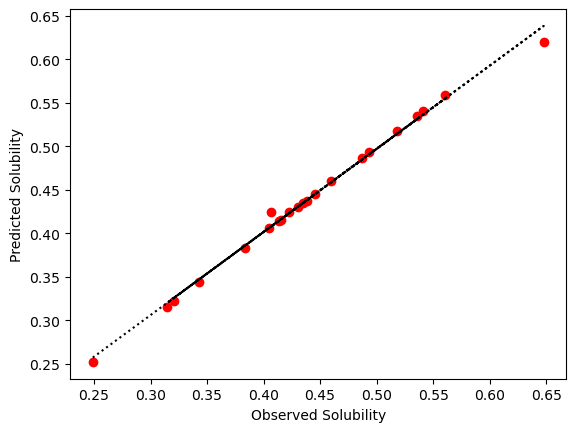

In [126]:
# Plot predicted vs observed for the first property (Solubility)
plt.scatter(Y_train[:, 0].cpu(), pred[:, 0], color = "red")
#plt.xlim(0, -50)
#plt.ylim(0, -50)
z = np.polyfit(Y_train[:, 0].cpu(), pred[:, 0],1)
p = np.poly1d(z)
plt.plot(Y_train[:, 0].cpu(),p(Y_train[:, 0].cpu()),":", color='black')
plt.xlabel('Observed Solubility')
plt.ylabel('Predicted Solubility')
#plt.title('Predicted vs Observed Solubility')
plt.show()

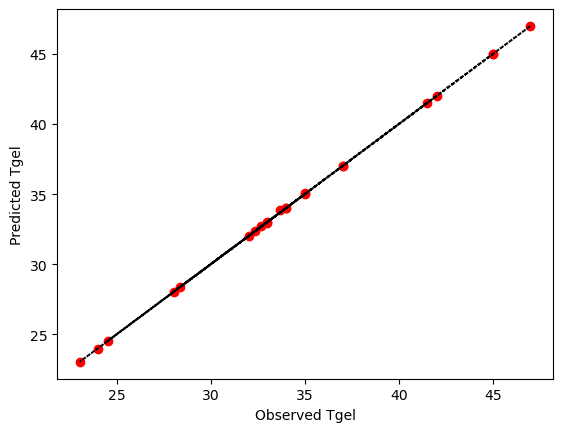

In [121]:
# Plot predicted vs observed for the second property (Tgel)
plt.scatter(Y_train[:, 1].cpu(), pred[:, 1], color = "red")
#plt.xlim(0, -50)
#plt.ylim(0, -50)
z = np.polyfit(Y_train[:, 1].cpu(), pred[:, 1],1)
p = np.poly1d(z)
plt.plot(Y_train[:, 1].cpu(),p(Y_train[:, 1].cpu()),":", color='black')
plt.xlabel('Observed Tgel')
plt.ylabel('Predicted Tgel')
#plt.title('Predicted vs Observed Tgel')
plt.show()

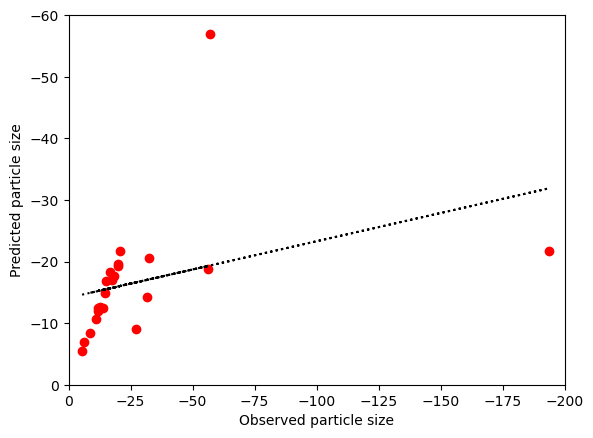

In [143]:
# Plot predicted vs observed for the second property (Particle Size)
plt.scatter(-Y_train[:, 2].cpu(), pred[:, 2], color = "red")
plt.xlim(0, -200)
plt.ylim(0, -60)
plt.xlabel('Observed particle size')
plt.ylabel('Predicted particle size')
#plt.title('Predicted vs Observed particle size')
z = np.polyfit(-Y_train[:, 2].cpu(), pred[:, 2],1)
p = np.poly1d(z)
plt.plot(-Y_train[:, 2].cpu(),p(-Y_train[:, 2].cpu()),":", color='black')
plt.show()

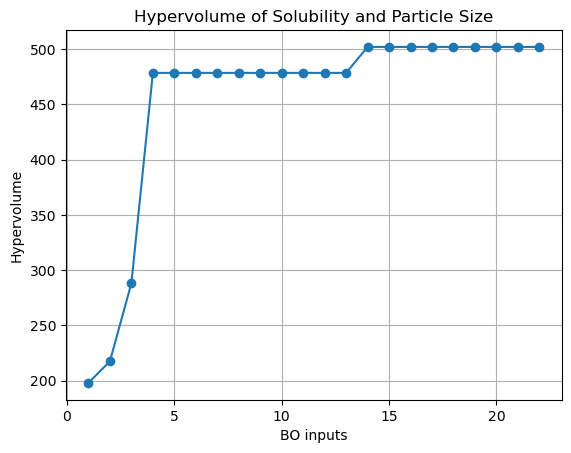

In [ ]:
from matplotlib import pyplot as plt
from botorch.utils.multi_objective.hypervolume import Hypervolume
hvs = []
ref_point = Y_train.min(dim=0).values
ref_neg = -Y_train.max(dim=0).values

Y_proc = Y_train.clone()


refp = torch.tensor([
    ref_point[0].item() - 0.1,   # Solubility (max): below min
    #ref_point[1].item() - 0.1,   # Tgel (max): below min
    ref_neg[2].item() + 0.1     # Particle_Size (min): above max
], device=device, dtype=tensor_float)

hv_metric = Hypervolume(refp)
for t in range(1, len(Y_proc)+1):
    hvs.append(hv_metric.compute(Y_proc[:t, [0,2]]))  

    # --- after you build `hvs` in your loop ---

# Ensure we have a 1D numpy array of floats
try:
    import numpy as np
    hv_vals = np.array([float(h.item()) if hasattr(h, "item") else float(h) for h in hvs])
except Exception:
    # fallback if any entries are tensors without .item
    hv_vals = np.array(hvs, dtype=float)

# Hypervolume difference per iteration (ΔHV)
hv_diff = np.diff(hv_vals, prepend=0.0)

#plt.ylim(10000,12000)
plt.plot(range(1, len(hvs)+1), hvs, marker='o')
plt.title("Hypervolume of Solubility and Particle Size")
plt.xlabel("BO inputs")
plt.ylabel("Hypervolume")
plt.grid(True)


#pd.DataFrame({'hypervolume': hvs}).to_csv("hypervolume.csv", index=False)


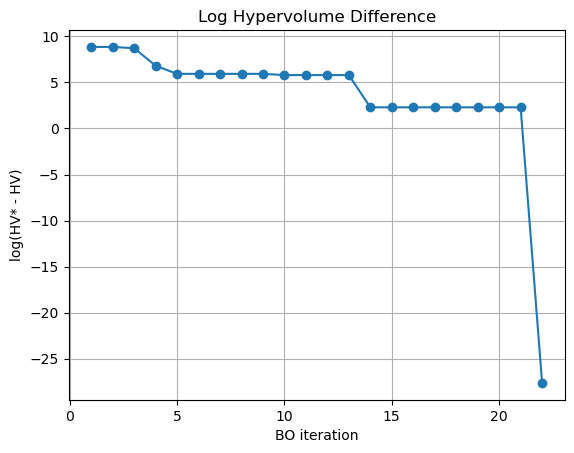

In [30]:
# Compute hypervolume values (already in hvs list)
import numpy as np

hv_vals = np.array([float(h.item()) if hasattr(h, "item") else float(h) for h in hvs])

# Define "true" hypervolume as the maximum observed HV across all iterations
hv_true = hv_vals.max()

# Compute log HV difference: log(HV* - HV_t)
hv_log_diff = np.log(hv_true - hv_vals + 1e-12)  # add epsilon to avoid log(0)
#hv_log_diff[hv_true - hv_vals <= 1e-12] = np.nan

# Plot
plt.figure()
plt.plot(range(1, len(hv_log_diff)+1), hv_log_diff, marker='o')
plt.title("Log Hypervolume Difference")
plt.xlabel("BO iteration")
plt.ylabel("log(HV* - HV)")
plt.grid(True)


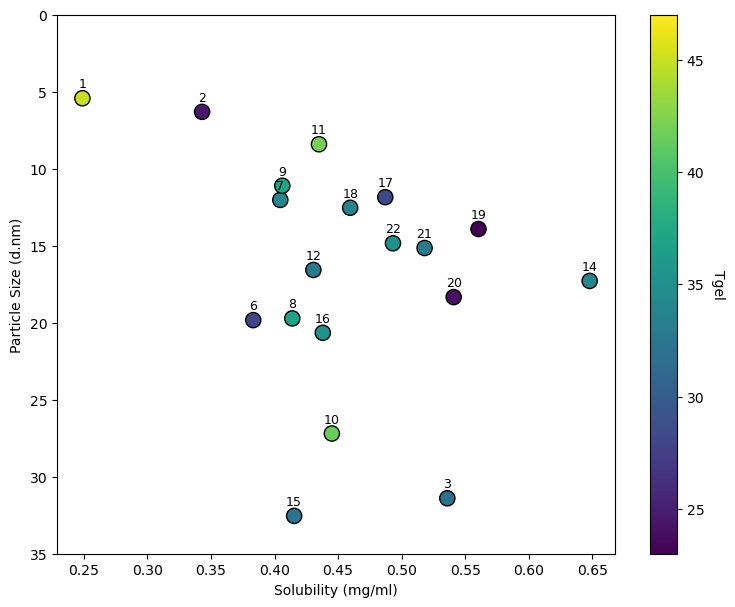

In [144]:
import numpy as np
import matplotlib.pyplot as plt

# Extract data for plotting
release = Y_train[:, 0].cpu().numpy()         # Solubility/Release
particle_size = Y_train[:, 2].cpu().numpy()   # Particle_Size
# Use the index as a proxy for the number of observations (order of entry)
# Use Tgel values for colormap

tgel = Y_train[:, 1].cpu().numpy()            # Tgel
num_obs = tgel
# Normalize Tgel for colormap
tgel_norm = (tgel - tgel.min()) / (tgel.max() - tgel.min())

plt.figure(figsize=(9, 7))
sc = plt.scatter(release, particle_size, c=num_obs, cmap='viridis', s=120, edgecolor='k')
cbar = plt.colorbar(sc)
cbar.set_label('Tgel', rotation=270, labelpad=15)
plt.xlabel('Solubility (mg/ml)')
plt.ylabel('Particle Size (d.nm)')
#plt.xlim(0.2, 0.7)
plt.ylim(0, 35)
plt.gca().invert_yaxis()
#plt.title('Pareto Front for all objectives')
plt.grid(False)

# Annotate each point with its index (formulation number)
for idx, (x, y) in enumerate(zip(release, particle_size)):
    plt.text(x, y-0.5, str(idx+1), fontsize=9, ha='center', va='bottom', alpha=1, clip_on=True)
plt.savefig("plot.png", bbox_inches="tight")

plt.show()



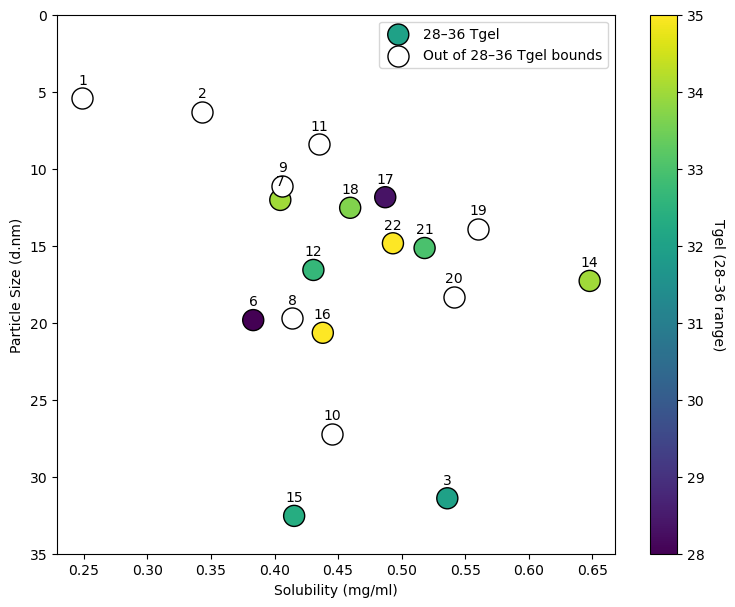

In [145]:
import numpy as np
import matplotlib.pyplot as plt

# Extract data
release = Y_train[:, 0].cpu().numpy()         # Solubility/Release
particle_size = Y_train[:, 2].cpu().numpy()   # Particle_Size
tgel = Y_train[:, 1].cpu().numpy()            # Tgel

# Boolean mask for in-range and out-of-range
mask_in = (tgel >= 28) & (tgel <= 36)
mask_out = ~mask_in

plt.figure(figsize=(9, 7))

# Plot in-range points (colormap)
sc = plt.scatter(
    release[mask_in], particle_size[mask_in],
    c=tgel[mask_in], cmap='viridis', s=230, edgecolor='k', label="28–36 Tgel"
)

# Plot out-of-range points (fixed color, e.g. red)
plt.scatter(
    release[mask_out], particle_size[mask_out],
    c='white', s=230, edgecolor='k', label="Out of 28–36 Tgel bounds"
)

# Colorbar for in-range points only
cbar = plt.colorbar(sc)
cbar.set_label('Tgel (28–36 range)', rotation=270, labelpad=15)

plt.xlabel('Solubility (mg/ml)')
plt.ylabel('Particle Size (d.nm)')
plt.ylim(0, 35)
plt.gca().invert_yaxis()
plt.grid(False)

# Annotate each point


for idx, (x, y, tg) in enumerate(zip(release, particle_size, tgel)):
    label = f"{idx+1}"
    if 23 <= idx+1 <= 27:
        label += "*"  # Add asterisk for samples 23–27
    plt.text(x, y-1.2, label, fontsize=10, ha='center', va='center', alpha=1, clip_on=True)

plt.legend()
#plt.savefig("plot.png", bbox_inches="tight")
plt.show()

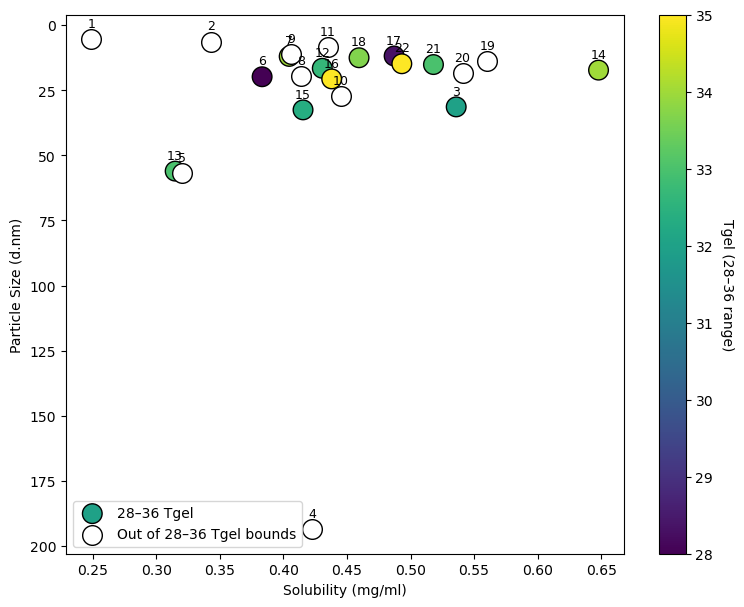

In [148]:
import numpy as np
import matplotlib.pyplot as plt

# Extract data
release = Y_train[:, 0].cpu().numpy()         # Solubility/Release
particle_size = Y_train[:, 2].cpu().numpy()   # Particle_Size
tgel = Y_train[:, 1].cpu().numpy()            # Tgel

# Boolean mask for in-range and out-of-range
mask_in = (tgel >= 28) & (tgel <= 36)
mask_out = ~mask_in

plt.figure(figsize=(9, 7))

# Plot in-range points (colormap)
sc = plt.scatter(
    release[mask_in], particle_size[mask_in],
    c=tgel[mask_in], cmap='viridis', s=200, edgecolor='k', label="28–36 Tgel"
)

# Plot out-of-range points (fixed color, e.g. red)
plt.scatter(
    release[mask_out], particle_size[mask_out],
    c='white', s=200, edgecolor='k', label="Out of 28–36 Tgel bounds"
)

# Colorbar for in-range points only
cbar = plt.colorbar(sc)
cbar.set_label('Tgel (28–36 range)', rotation=270, labelpad=15)

plt.xlabel('Solubility (mg/ml)')
plt.ylabel('Particle Size (d.nm)')
#plt.ylim(0, 35)
plt.gca().invert_yaxis()
plt.grid(False)

# Annotate each point


for idx, (x, y, tg) in enumerate(zip(release, particle_size, tgel)):
    label = f"{idx+1}"
    if 23 <= idx+1 <= 27:
        label += "*"  # Add asterisk for samples 23–27
    plt.text(x, y-6, label, fontsize=9, ha='center', va='center', alpha=1, clip_on=True)

plt.legend()
#plt.savefig("plot.png", bbox_inches="tight")
plt.show()

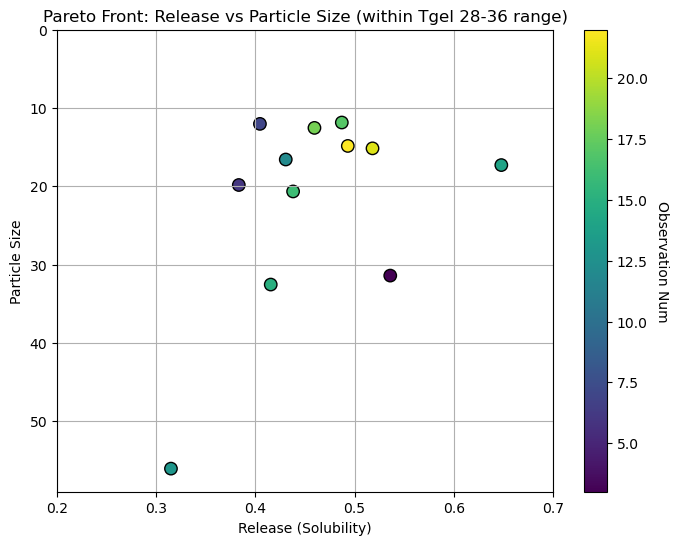

In [70]:
import numpy as np

# Filter samples with Tgel in the range [28, 36]
mask_tgel = (Y_train[:, 1].cpu().numpy() >= 28) & (Y_train[:, 1].cpu().numpy() <= 36)
release = Y_train[:, 0].cpu().numpy()[mask_tgel]
particle_size = Y_train[:, 2].cpu().numpy()[mask_tgel]
num_obs = np.arange(1, len(Y_train) + 1)[mask_tgel]
tgel = Y_train[:, 1].cpu().numpy()[mask_tgel]



# Normalize Tgel for colormap
tgel_norm = (tgel - tgel.min()) / (tgel.max() - tgel.min())

plt.figure(figsize=(8, 6))
sc = plt.scatter(release, particle_size, c=num_obs, cmap='viridis', s=80, edgecolor='k')
cbar = plt.colorbar(sc)
cbar.set_label('Observation Num', rotation=270, labelpad=15)
plt.xlabel('Release (Solubility)')
plt.ylabel('Particle Size')
plt.xlim(0.2, 0.7)
plt.ylim(0, 59)
plt.gca().invert_yaxis()
plt.title('Pareto Front: Release vs Particle Size (within Tgel 28-36 range)')
plt.grid(True)

plt.show()

UMAP, can use this to see if there is any excipients to performance relationship

c:\Users\72784\anaconda3\envs\pytorch_clean\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


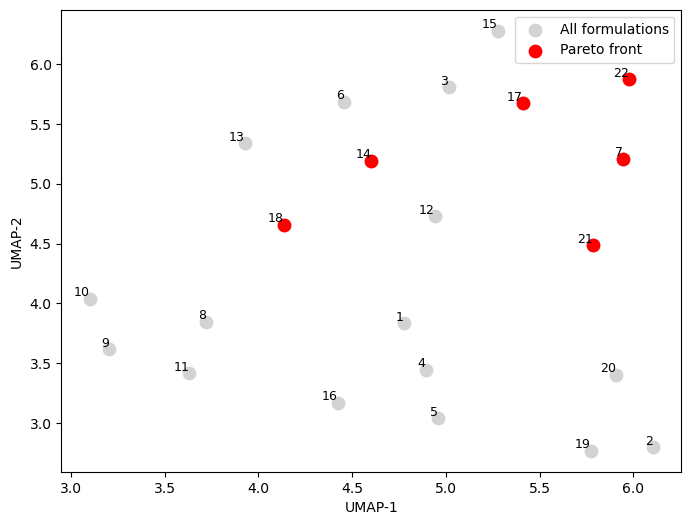

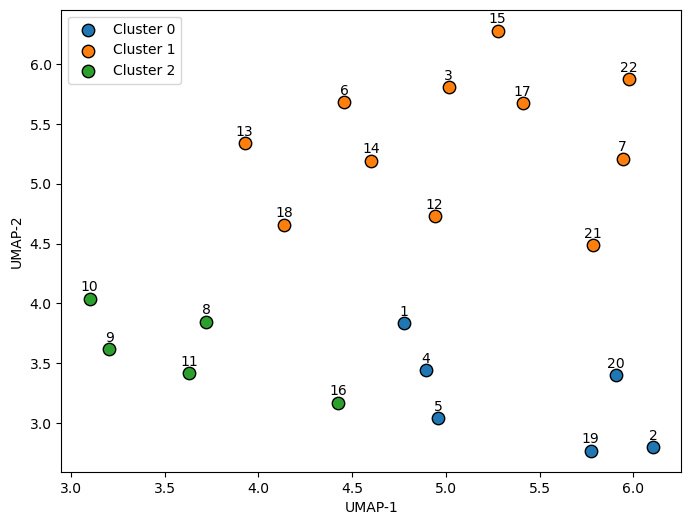

In [177]:
import umap
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Select excipient columns for UMAP
X_design = df[excipient_cols].values

# Standardize features for UMAP
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_design)

# UMAP dimension reduction to 2D
umap_model = umap.UMAP(n_components=2, random_state=42)
X_umap = umap_model.fit_transform(X_scaled)

#KMeans clustering (choose n_clusters, e.g. 3) 
n_clusters = 3 
kmeans = KMeans(n_clusters=n_clusters, random_state=8) 
labels = kmeans.fit_predict(X_umap)

# ---- Instead of clustering, just plot all grey ----
plt.figure(figsize=(8,6))
plt.scatter(X_umap[:, 0], X_umap[:, 1], color="lightgrey", s=80, label="All formulations")

# Replace this with actual Pareto front IDs
pareto_ids = [21, 17, 18,14, 22, 7]  

# Convert to 0-based indices
pareto_idx = [i-1 for i in pareto_ids]

# Highlight Pareto front points in red
plt.scatter(X_umap[pareto_idx, 0], X_umap[pareto_idx, 1],
            color="red", s=80, label="Pareto front")

# Annotate each point with its index (formulation number)
for idx, (x, y) in enumerate(X_umap):
    plt.text(x, y, str(idx+1), fontsize=9, ha='right', va='bottom')

plt.xlabel('UMAP-1')
plt.ylabel('UMAP-2')
plt.legend()
plt.grid(False)


plt.figure(figsize=(8,6))
for i in range(n_clusters):
    plt.scatter(X_umap[labels == i, 0], X_umap[labels == i, 1], label=f'Cluster {i}', s=80, edgecolor='k')
# Annotate each point with its index (or any identifier, e.g. formulation number)
for idx, (x, y) in enumerate(X_umap):
    plt.text(x, y+0.04, str(idx+1), fontsize=10, ha='center', va='bottom')
plt.xlabel('UMAP-1')
plt.ylabel('UMAP-2')
#plt.title('UMAP Dimension Reduction & KMeans Clustering of Excipient Formulations')
plt.legend()
plt.grid(False)
plt.show()

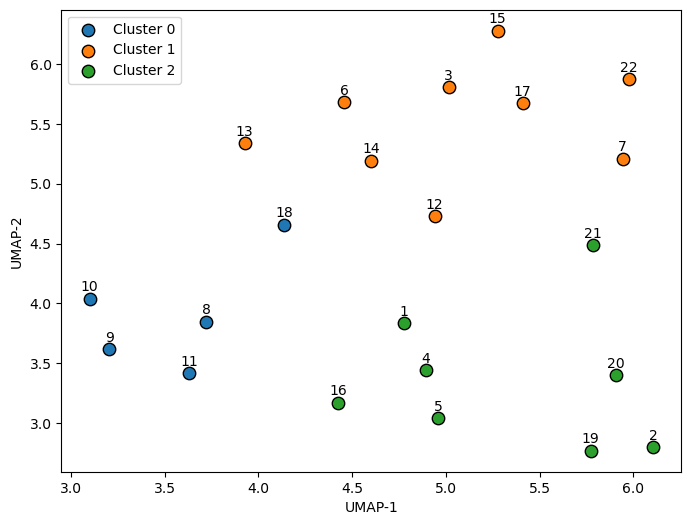

In [155]:
plt.figure(figsize=(8,6))
for i in range(n_clusters):
    plt.scatter(X_umap[labels == i, 0], X_umap[labels == i, 1], label=f'Cluster {i}', s=80, edgecolor='k')
# Annotate each point with its index (or any identifier, e.g. formulation number)
for idx, (x, y) in enumerate(X_umap):
    plt.text(x, y+0.04, str(idx+1), fontsize=10, ha='center', va='bottom')
plt.xlabel('UMAP-1')
plt.ylabel('UMAP-2')
#plt.title('UMAP Dimension Reduction & KMeans Clustering of Excipient Formulations')
plt.legend()
plt.grid(False)
plt.show()